<a href="https://colab.research.google.com/github/buceleasebastian/GAN/blob/main/DCGAN/DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import torch
import random
import torchvision
import torchvision.utils as utils
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib as plt
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.conv import ConvTranspose2d


"""Generator and Discriminator hyperparameters

Parameters taken as arguments in the initialization of the Generator and Discriminator Network

Parameters

----------
n_channels : number of channels of the image, corresponds to the number of channel of the input for the discriminator and the output for the generator - set to 3 for an RGB image
size_latent : size of the latent noise vector taken as input for the Generator
disc_features : size of the feature maps passed as input for the discriminator
gen_features : size of feature maps (images obtained after applying the convolution) in the generator
transforms : Pytorch normalization of images 
----------

References 

----------

  [1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
  [2^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""


#device initialization
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

#Number of channels of the training images
n_channels = 1

#Size of the latent vector
size_latent = 100

#Discriminator feature maps size
disc_features = 32

#Generator feature maps size
gen_features = 32

#Image size 
image_size = 32

#Transforms : general normalization regardless of the channel image
transforms = transforms.Compose([transforms.Resize(image_size), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize(
                                 [0.5 for channel in range(n_channels)], [0.5 for channel in range(n_channels)],)])

#Deep Convolutional Generative Adversarial Networks

#Data Loading

In [2]:
#The dataset can be downloaded at the following link : 
data = datasets.MNIST(root="https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html", download = True, transform=ToTensor())


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html/MNIST/raw/train-images-idx3-ubyte.gz to https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html/MNIST/raw/train-labels-idx1-ubyte.gz to https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html/MNIST/raw/t10k-images-idx3-ubyte.gz to https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html/MNIST/raw/t10k-labels-idx1-ubyte.gz to https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html/MNIST/raw



In [3]:
dataloader = DataLoader(data, batch_size=64, shuffle=True, num_workers=2)

#Parameter Initialization

##Image hyperparameters

##Optimization parameters

In [4]:
"""Optimization hyperparameters

Parameters taken as arguments during training 

Parameters

----------
batch_size : number of samples that 
lr : learning rate, dictates the pace at which the networks update the values of parameter estimates
beta : 
----------

References 

----------

[1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
[2^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""
#Batch size
batch_size = 32

#Optimizer learning rate
lr = 0.0002

#Adam optimizer hyperparameter 
beta1 = 0.5
beta2 = 0.9999

#Number of training epochs
epochs = 5

#Data description

##Plotting some images from the datase

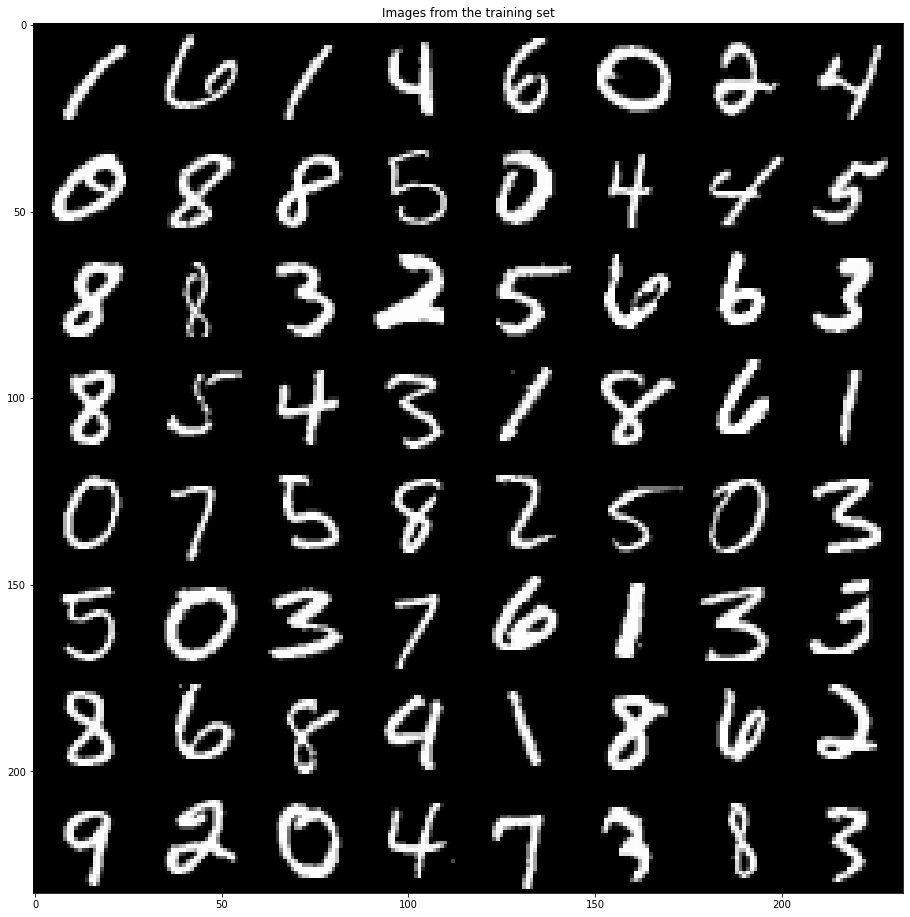

In [5]:
batch = next(iter(dataloader))
plt.figure(figsize = (16,16))
plt.title("Images from the training set")
plt.imshow(np.transpose(utils.make_grid(batch[0].to(device)[:64], padding = 1, normalize = True).cpu(),(1,2,0)))

#Generator and Discriminator

##Generator

In [6]:
"""Generator class Network
  
  Class inherits from pytorch Neural Network Module
  We are taking the noise vector and then we are passing 2D Transposed Convolutional layers, that are paired with Batch Normalization Layers and a ReLU activation function.
  Class is composed by the __init__ function for initialization and a function __layers which corresponds to a block of a Convolutional 2D layer, a Batch Normalization Layer 
  and the ReLU activation function.

  Parameters

  ----------
  latent_dim : dimension of the latent noise vector
  channels : number of channels of the output image
  gen_features : size of feature maps (images obtained after applying the convolution) in the generator 
  ----------

  References 

  ----------

  [1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
  [2^]  [DCGAN Repository] (https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/model.py)

  """

class Generator(nn.Module):

   def __init__(self, latent_dim, channels, gen_features): 
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
       #Convolution of input Z
       self._layers(latent_dim, gen_features*4, 4, 1, 0),
      
       #Dimension gen_features*4 x 8 x 8
       self._layers(gen_features*4, gen_features*2, 3, 2, 1),

       #Dimension gen_features*2 x 16 x 16
       self._layers(gen_features*2, gen_features, 4, 2, 1),

       #Dimension gen_features x 32 x 32
       nn.ConvTranspose2d(gen_features, 
                         channels, 
                         kernel_size = 4, 
                         stride = 2, 
                         padding = 1
                          ),
      nn.Tanh()
      )
 
  #Creation of block of layers : Transposed Convolution, Batch Normalization, ReLU 
   def _layers(self, channels_input, channels_output, kernel_size, stride, padding): 
      return nn.Sequential(
          nn.ConvTranspose2d(channels_input, 
                             channels_output,
                             kernel_size,
                             stride, 
                             padding, 
                             bias = False),
          nn.BatchNorm2d(channels_output),
          nn.ReLU(),
      )


   def forward(self, x):
     return self.gen(x)

##Discriminator

In [7]:
  """Discriminator Class Network

  Class inherits from pytorch Neural Network Module
  Takes an image as input and outputs the probability that the image is real by applying a series of Convolutional 2D, Batch Normalization and LeakyReLU layers using function _layers.
  Output is generated through a sigmoid function.

  Parameters

  ----------  
  channels : number of channels in the initial image
  disc_features : number of channels that are going to change as we are passing through the discriminator
  ----------

  References 

  ----------

  [1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
  [2^]  [DCGAN Repository] (https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/model.py)

  """

class Discriminator(nn.Module):

 def __init__(self, channels, disc_features):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        #Input : N x channels x 64 x 64
        nn.Conv2d(
            channels, 
            disc_features, 
            kernel_size = 4, 
            stride = 2, 
            padding = 1
        ),
        nn.LeakyReLU(0.2),
        
        #Dimension disc_features x 32 x 32
        self._layers(disc_features, disc_features*2, 1, 2, 1),

        #Dimension disc_features x 8 x 8
        self._layers(disc_features*2, disc_features*4, 1, 2, 1),
        
        #Dimension disc_feature x 2 x 2
        nn.Conv2d(disc_features*4, 1, 1, 2, 0),
        nn.Sigmoid()
    )
   
    #Creation of block of layers : convolution, normalization, LeakyReLU
 def _layers(self, channels_input, channels_output, kernel_size, stride, padding):
       return nn.Sequential(
         nn.Conv2d(
            channels_input,
            channels_output,
            kernel_size,
            stride,
            padding,
            bias = False
        ),
        nn.BatchNorm2d(channels_output),
        nn.LeakyReLU(0.2)
    )

  
 def forward(self, x):
      return self.disc(x)

##Weights initialization

In [8]:
#Initialization of Normally distributed weights with mean 0 and sd 0.2
def weights_initialization(model):

  
  """Weights initialization function

  Takes model as input and initializes the weights in each of its layer
  Initialization of Normally distributed weights with mean 0 and standard deviation 0.2

  Parameters

  ----------  
  model : Generator or discriminator, taken as input
  ----------

  References 

  ----------

  [1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
  [2^]  [DCGAN Repository] (https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/model.py)
"""

  for module in model.modules():
    if module == nn.Conv2d or module == nn.ConvTranspose2d or module == nn.BatchNorm2d :
      nn.init.normal_(model.weight.data, 0.0, 0.02)

##Training and test setup

##Training Loop

In [9]:
"""Training Loop

Initialization of Generator and Discriminator, initialization of their weights and optimizers
Initialization of Binary Cross-Entropy as loss function
Initialization of empty lists of losses


References 

----------

[1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
[2^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""



#Networks initialization with given hyperparameters
disc = Discriminator(n_channels, disc_features).to(device)
gen = Generator(size_latent, n_channels, gen_features).to(device)

#Weights initialization with mean 0 and sd 0.2
weights_initialization(disc)
weights_initialization(gen)

#Adam optimizers initialization for Discriminator and Generator with beta velus corresponding to the paper
gen_optimizer = optim.Adam(gen.parameters(), lr = lr, betas = (beta1, beta2))
disc_optimizer = optim.Adam(disc.parameters(), lr = lr, betas = (beta1, beta2))

#Binary Cross-Entropy loss criterion
criterion = nn.BCELoss()

#Training step
step = 0

#Initial noise vector initialization for further comparison
init_noise = torch.randn(32, size_latent, 1, 1).to(device)

gen.train()
disc.train()

#List of losses
D_losses = []
G_losses = []
img_list = []

#Training Loop
for epoch in range(epochs):
  for batch, (real_image, targets) in enumerate(dataloader):
    print("Batch number " + str(batch))
    
    #Uploading real image to gpu
    real_image = real_image.to(device)

    #Generating noise vectors
    noise = torch.randn((batch_size, size_latent, 1, 1)).to(device)
    
    #Generating fake image from noise
    fake = gen(noise)

    #Train discriminator

    #Discriminator on real image
    disc_real = disc(real_image).reshape(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))


    #Discriminator on fake image
    disc_fake = disc(fake).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    disc_loss = (loss_disc_real + loss_disc_fake)
    D_losses.append(disc_loss.item())
    print("Discriminator Loss :" + str(disc_loss))

    #Discriminator loss optimization
    disc.zero_grad()
    disc_loss.backward(retain_graph = True)
    disc_optimizer.step()


    #Train generator

    #Discriminate fake and get loss
    output = disc(fake).reshape(-1)
    generator_loss = criterion(output, torch.ones_like(output))
    G_losses.append(generator_loss.item())
    print("Generator Loss :" + str(generator_loss))

    #Generator Adam optimization
    gen.zero_grad()
    generator_loss.backward()
    gen_optimizer.step()

    if step % 1000 == 0:

      with torch.no_grad():
        fake = gen(init_noise).detach().cpu()
      img_list.append(fake)
    step = step + 1


Streaming output truncated to the last 5000 lines.
Discriminator Loss :tensor(1.1848, grad_fn=<AddBackward0>)
Generator Loss :tensor(0.8852, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 210
Discriminator Loss :tensor(1.0451, grad_fn=<AddBackward0>)
Generator Loss :tensor(0.9948, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 211
Discriminator Loss :tensor(1.1252, grad_fn=<AddBackward0>)
Generator Loss :tensor(0.9111, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 212
Discriminator Loss :tensor(1.0759, grad_fn=<AddBackward0>)
Generator Loss :tensor(1.0283, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 213
Discriminator Loss :tensor(1.0718, grad_fn=<AddBackward0>)
Generator Loss :tensor(1.0267, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 214
Discriminator Loss :tensor(1.1011, grad_fn=<AddBackward0>)
Generator Loss :tensor(0.9317, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 215
Discriminator Loss :tensor(1.1619, grad_fn=<AddBackward0>)
Generator Loss

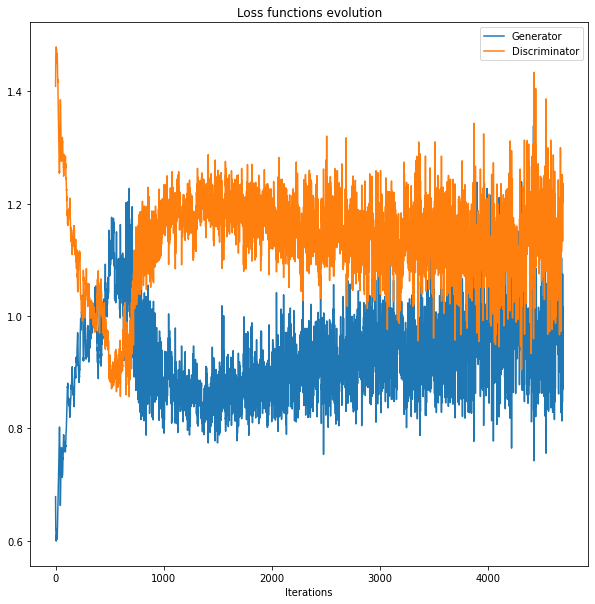

In [10]:
"""Plot of objective functions

Loss function should be decreasing for the Discriminator, while the objective function should be increasing

References 

----------

[1^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""


#Graph of objective functions
plt.figure(figsize = (10,10))
plt.title("Loss functions evolution")
plt.plot(G_losses, label = "Generator")
plt.plot(D_losses, label = "Discriminator")
plt.xlabel("Iterations")
plt.legend()
plt.show()

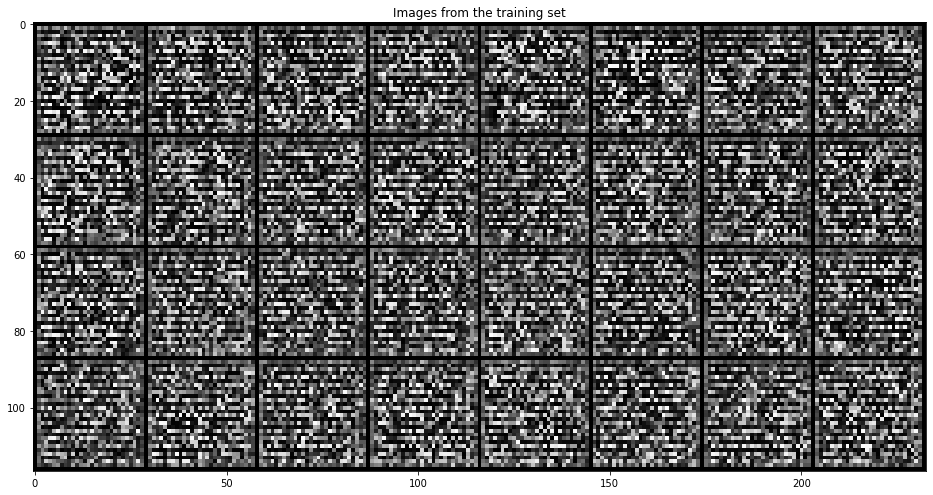

In [11]:
"""Plot of obtained images throught imshow


References 

----------

[1^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""

image = next(iter(img_list))
plt.figure(figsize = (16,16))
plt.title("Images from the training set")
plt.imshow(np.transpose(utils.make_grid(image.to(device)[:64], padding = 1, normalize = True).cpu(),(1,2,0)))

# WGAN training

In [ ]:
#Hyperparameters for training setup

lr = 0.0005
batch_size = 64
latent_dim = 100
epochs = 5

#Additional hyperparameters for WGAN
critic_iterations = 5
weight_clip = 0.01

#Optimizers for WGAN
gen_optimizer = optim.RMSprop(gen.parameters(), lr = lr)
disc_optimizer = optim.RMSprop(disc.parameters(), lr = lr)



#Training Loop
for epoch in range(epochs):
  for batch, (real_image, targets) in enumerate(dataloader):
    print("Batch number " + str(batch))
    
    #Uploading real image to gpu
    real_image = real_image.to(device)

    #Generating noise vectors
    noise = torch.randn((batch_size, size_latent, 1, 1)).to(device)
    
    #Generating fake image from noise
    fake = gen(noise)

    #Train discriminator

    #Discriminator on real image
    disc_real = disc(real_image).reshape(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

    #Discriminator on fake image
    disc_fake = disc(fake).reshape(-1)

    disc_optimizer.step()


    #Train generator

    #Discriminate fake and get loss
    output = disc(fake).reshape(-1)
    generator_loss = criterion(output, torch.ones_like(output))
    print("Generator Loss :" + str(generator_loss))
    G_losses.append(generator_loss)

    #Generator Adam optimization
    gen.zero_grad()
    generator_loss.backward()
    gen_optimizer.step()

    if batch % 100 == 0:

      with torch.no_grad():
        fake = gen(init_noise).detach().cpu()
        img_list.append(utils.make_grid(fake, padding = 2, normalize = True))
        step = step + 1


Batch number 0
Generator Loss :tensor(1.1991, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 1
Generator Loss :tensor(0.8613, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 2
Generator Loss :tensor(0.2787, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 3
Generator Loss :tensor(0.1148, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 4
Generator Loss :tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 5
Generator Loss :tensor(0.0324, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 6
Generator Loss :tensor(0.0170, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 7
Generator Loss :tensor(0.0157, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 8
Generator Loss :tensor(0.0115, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 9
Generator Loss :tensor(0.0063, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 10
Generator Loss :tensor(0.0061, grad_fn=<BinaryCrossEntropyBackward0>)
Batch number 11
Generator Loss :tensor(0.0070, grad_fn=<BinaryCr